# Computational Cognitive Neuroscience Practical Assignment 6
## Generative adversarial networks
### Tommy Clausner (s4836219) and Steven Smits (s4237263)

In [1]:
import chainer,math,time
import matplotlib.pyplot as plt
import numpy as np
from chainer import optimizers
import chainer.functions as F
import chainer.links as L

## get_mnist() as provided by the teacher

In [2]:
def get_mnist(n_train=1000, n_test=100, n_dim=1, with_label=False, classes = [0]):
    """

    :param n_train: nr of training examples per class
    :param n_test: nr of test examples per class
    :param n_dim: 1 or 3 (for convolutional input)
    :param with_label: whether or not to also provide labels
    :param classes: if not None, then it selects only those classes, e.g. [0, 1]
    :return:
    """

    train_data, test_data = chainer.datasets.get_mnist(ndim=n_dim, withlabel=with_label)

    if not classes:
        classes = np.arange(10)
    n_classes = len(classes)

    if with_label:

        for d in range(2):

            if d==0:
                data = train_data._datasets[0]
                labels = train_data._datasets[1]
                n = n_train
            else:
                data = test_data._datasets[0]
                labels = test_data._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i==0:
                    idx = lidx
                else:
                    idx = np.hstack([idx,lidx])

            L = np.concatenate([i*np.ones(n) for i in np.arange(n_classes)]).astype('int32')

            if d==0:
                train_data = chainer.datasets.TupleDataset(data[idx],L)
            else:
                test_data = chainer.datasets.TupleDataset(data[idx],L)

    else:

        tmp1, tmp2 = chainer.datasets.get_mnist(ndim=n_dim,withlabel=True)

        for d in range(2):

            if d == 0:
                data = train_data
                labels = tmp1._datasets[1]
                n = n_train
            else:
                data = test_data
                labels = tmp2._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i == 0:
                    idx = lidx
                else:
                    idx = np.hstack([idx, lidx])

            if d == 0:
                train_data = data[idx]
            else:
                test_data = data[idx]

    return train_data, test_data

### Generator network

In [3]:
class generator(chainer.Chain):
    def __init__(self,nodes_):
        super(generator, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(nodes_, 3*3*784) # linear input layer
            self.l2 = L.BatchNormalization(3 * 3 * 784) # applying batch normalization
            self.l3 = L.Deconvolution2D(784, 784, 1,pad=1) # applying deconvolution

    def __call__(self, x):
        h = F.relu(self.l1(x)) # rectified activation function
        h = self.l2(h)
        h = F.reshape(h,(x.data.shape[0], 784, 3, 3))
        h = F.sigmoid(self.l3(h)) # sigmoid activation function
        return h

### Discriminator network

In [4]:
class discriminator(chainer.Chain):
    def __init__(self):
        super(discriminator, self).__init__()
        with self.init_scope():
            self.l1 = L.Convolution2D(784, 784, 1, pad=1) # convolutional layer
            self.l2 = L.Linear(3 * 3 * 784, 2) # linear output layer

    def __call__(self, x):
        h = F.relu(self.l1(x))
        return self.l2(h)

### additional functions for convenience

In [5]:
def mediansmooth(datain, kernelwidth):

    # note: this guy is only for plotting purposes and does what you'd expect: a median smooth

    padd_beg = int(math.ceil((float(kernelwidth) / 2)))
    padd_end = int(math.floor((float(kernelwidth) / 2)))

    padd_beg = np.empty((padd_beg))
    padd_beg[:] = np.NAN

    padd_end = np.empty((padd_end))
    padd_end[:] = np.NAN

    datatmp = np.concatenate((padd_beg, datain, padd_end))

    x = np.size(np.matrix(datatmp), 1)
    data_pre = np.empty((x, kernelwidth), dtype=np.float32)
    data_pre[:] = np.NAN

    for i in range(0, kernelwidth):
        data_pre[range(0, x - i), i] = datatmp[range(i, x)]

    data_pre = data_pre[range(1, x - kernelwidth + 1)]
    data_out = np.nanmedian(data_pre, axis=1)

    return data_out

def createexampleplot(x,numit):
    # plotting example image data
    plt.figure()
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(x.data[i].reshape(28,28))
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
    plt.suptitle('Generated after ' + str(numit + 1) + ' iterations')
    plt.show()

### Iterative training

done: 0.05% - Estimated time left: 75.1600968838s


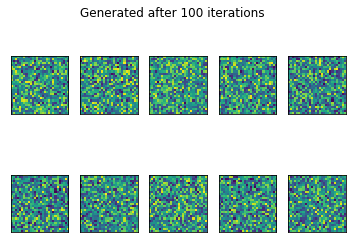

done: 5.0% - Estimated time left: 67.8218483925s
done: 9.95% - Estimated time left: 62.0767941487s
done: 14.9% - Estimated time left: 56.2679070402s
done: 19.85% - Estimated time left: 51.9140082835s
done: 24.8% - Estimated time left: 48.0222456225s


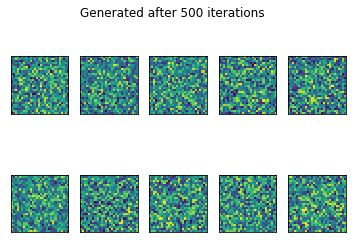

done: 29.75% - Estimated time left: 46.816082724s
done: 34.7% - Estimated time left: 43.7269476628s
done: 39.65% - Estimated time left: 40.3191450472s
done: 44.6% - Estimated time left: 36.7874584743s
done: 49.55% - Estimated time left: 33.2247604034s


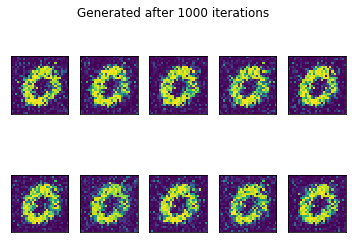

done: 54.5% - Estimated time left: 30.2639792665s
done: 59.45% - Estimated time left: 26.7639921706s
done: 64.4% - Estimated time left: 23.341510752s
done: 69.35% - Estimated time left: 19.9815556993s
done: 74.3% - Estimated time left: 16.676081583s
done: 79.25% - Estimated time left: 13.4434878352s
done: 84.2% - Estimated time left: 10.2450819412s
done: 89.15% - Estimated time left: 7.01224512059s
done: 94.1% - Estimated time left: 3.80068592032s
done: 99.05% - Estimated time left: 0.614925902038s


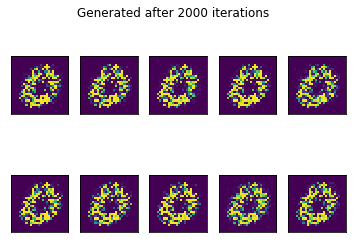

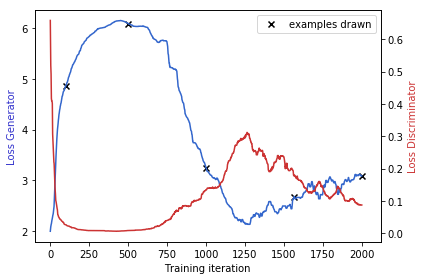

Discriminator Accuracy: 1.0


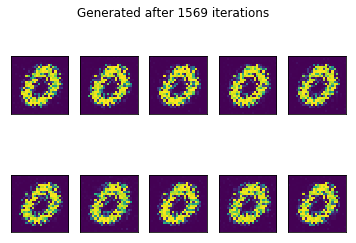

In [6]:
train_data, test_data = get_mnist(n_train=1000,n_test=100,with_label=False,classes= [0]) # get training + test data

num_train_it=2000 # training iterations
nodes_=100 # number of neurons for the input layer of the generator
batchsize=10 # size of minibatches

dis=discriminator() # create discriminator network
gen=generator(nodes_) # create generator network

# setting up optimizer funcrions using SGD + momentum as discribed in (Goodfellow et al., 2014)
opti_gen = optimizers.MomentumSGD(lr=0.001,momentum=0.9)
opti_gen.setup(gen)

opti_dis = optimizers.MomentumSGD(lr=0.001,momentum=0.9)
opti_dis.setup(dis)

# collector variables for losses
losscoll_dis=[]
losscoll_gen=[]

loss_min=np.inf
start_time=time.time()

# iterative training
for trainit in range(num_train_it):

    input_G = chainer.Variable(np.random.uniform(-1, 1, (batchsize, nodes_)).astype('float32')) # initialize seeds for the generator

    fake_X = gen(input_G) # generate examples

    judge_fake=dis(fake_X) # classify generated examples

    Loss_gen = F.softmax_cross_entropy(judge_fake, chainer.Variable(np.zeros(batchsize, dtype=np.int32))) # obtain generator loss

    randind_traindata = np.int32((np.random.rand(batchsize) * (len(train_data) - batchsize - 1)).round())

    real_X=train_data[randind_traindata].reshape(batchsize,784,1,1) # select random training data

    judge_real=dis(chainer.Variable(real_X))

    # obtain discriminator loss
    Loss_dis = F.softmax_cross_entropy(judge_fake, chainer.Variable(np.ones(batchsize, dtype=np.int32)))+\
               F.softmax_cross_entropy(judge_real, chainer.Variable(np.zeros(batchsize, dtype=np.int32)))

    # update generator
    gen.cleargrads();Loss_gen.backward();opti_gen.update()

    # update discriminator
    dis.cleargrads();Loss_dis.backward();opti_dis.update()

    losscoll_gen.append(Loss_gen.data)
    losscoll_dis.append(Loss_dis.data)

    # the rest is for plotting
    if trainit==99 or trainit==499 or trainit==999 or trainit==1999:
        createexampleplot(fake_X,trainit)

    if Loss_gen.data<loss_min and trainit>(num_train_it*0.1): # save the best "fake_X"
        loss_min=Loss_gen.data
        best_trainit=trainit
        best_rec=fake_X

    if np.remainder(trainit,99)==0:
        print('done: ' + str(np.float32(trainit+1) / num_train_it * 100.) + '% - Estimated time left: ' + str(
            (time.time() - start_time) / (trainit + 1.) * num_train_it - (time.time() - start_time)) + 's')

fig, ax1 = plt.subplots()
plt.plot(mediansmooth(losscoll_gen,50),color=[0.2,0.4,0.8])
plt.scatter([99,499,999,1999,best_trainit],np.vstack(mediansmooth(losscoll_gen,50))[[99,499,999,1999,best_trainit]],color='k',marker='x',label='examples drawn')
plt.legend()
ax1.set_ylabel('Loss Generator',color=[0.2,0.2,0.8])
plt.xlabel('Training iteration')

ax2 = ax1.twinx()
ax2.plot(mediansmooth(losscoll_dis,50),color=[0.8,0.2,0.2])
ax2.set_ylabel('Loss Discriminator',color=[0.8,0.2,0.2])
fig.tight_layout()
plt.show()

input_G = chainer.Variable(np.random.uniform(-1, 1, (len(test_data), nodes_)).astype('float32'))
judge_fake=dis(gen(input_G))
judge_real=dis(chainer.Variable(test_data.reshape(len(test_data),784,1,1)))

print('Discriminator Accuracy: '+str(np.sum(np.int32(judge_fake[:,0].data<0)+np.int32(judge_real[:,0].data>0))/(len(test_data)*2.)))
createexampleplot(best_rec,best_trainit+1)

### Discussion

When inspecting the loss functions it becomes apparent, that the discriminator learns very fast in the beginning to detect the fake images created by the generator. The generator in turn learns how to create "good" fake stimuli and when both lines cross, managed to fool the discriminator. The latter in turn keeps up learning to distinguish the better fakes and at the end of the learning both seem to be somewhat balanced.

The final results (of the generator) however seem not to reflect the best solution it found during the learning. For this reason and example is plotted at the respective training stage, where the loss was lowest for the generator.

### Bonus - *whoopee* - using a linear MLP

We found out that the whole thing works quite nice without (de-)convolutional layers. It's faster and the generated images look quite similar.

Loss Discriminative model epoch  1 :  1.14676825523
Loss Generative model epoch  1 :  4.55095574617
Loss Discriminative model epoch  2 :  1.39822613239
Loss Generative model epoch  2 :  3.84200778246
Loss Discriminative model epoch  3 :  1.36347425461
Loss Generative model epoch  3 :  4.01959577322
Loss Discriminative model epoch  4 :  1.2583057189
Loss Generative model epoch  4 :  3.87393996716
Loss Discriminative model epoch  5 :  1.23744451284
Loss Generative model epoch  5 :  3.90807179451


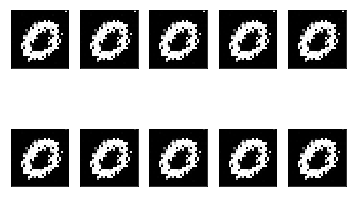

In [7]:
from __future__ import print_function
import numpy as np
import chainer
from chainer import optimizers
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TupleDataset
import matplotlib.pyplot as plt

def plot_batch(G_model, row=2, col=5, size=10):
    """Plots size number of predictions based generator model G_model."""
    G_input = G_model(chainer.Variable(np.random.uniform(0, 1, (size, 28 * 28)).astype(np.float32)))
    plt.figure()
    for i in range(G_input.shape[0]):
        G_im = G_input[i].reshape([28, 28]).data
        plt.subplot(row, col, i + 1)
        plt.imshow(G_im, cmap='gray')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    plt.show()

def get_mnist(n_train=100, n_test=100, n_dim=1, with_label=True, classes = None):
    """

    :param n_train: nr of training examples per class
    :param n_test: nr of test examples per class
    :param n_dim: 1 or 3 (for convolutional input)
    :param with_label: whether or not to also provide labels
    :param classes: if not None, then it selects only those classes, e.g. [0, 1]
    :return:
    """

    train_data, test_data = chainer.datasets.get_mnist(ndim=n_dim, withlabel=with_label)

    if not classes:
        classes = np.arange(10)
    n_classes = len(classes)

    if with_label:

        for d in range(2):

            if d==0:
                data = train_data._datasets[0]
                labels = train_data._datasets[1]
                n = n_train
            else:
                data = test_data._datasets[0]
                labels = test_data._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i==0:
                    idx = lidx
                else:
                    idx = np.hstack([idx,lidx])

            L = np.concatenate([i*np.ones(n) for i in np.arange(n_classes)]).astype('int32')

            if d==0:
                train_data = TupleDataset(data[idx],L)
            else:
                test_data = TupleDataset(data[idx],L)

    else:

        tmp1, tmp2 = chainer.datasets.get_mnist(ndim=n_dim,withlabel=True)

        for d in range(2):

            if d == 0:
                data = train_data
                labels = tmp1._datasets[1]
                n = n_train
            else:
                data = test_data
                labels = tmp2._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i == 0:
                    idx = lidx
                else:
                    idx = np.hstack([idx, lidx])

            if d == 0:
                train_data = data[idx]
            else:
                test_data = data[idx]

    return train_data, test_data

class RandomIterator(object):
    """
    Generates random subsets of data
    """

    def __init__(self, data, batch_size=1):
        """

        Args:
            data (TupleDataset):
            batch_size (int):

        Returns:
            list of batches consisting of (input, output) pairs
        """

        self.data = data

        self.batch_size = batch_size
        self.n_batches = len(self.data) // batch_size

    def __iter__(self):

        self.idx = -1
        self._order = np.random.permutation(len(self.data))[:(self.n_batches * self.batch_size)]

        return self

    def next(self):

        self.idx += 1

        if self.idx == self.n_batches:
            raise StopIteration

        i = self.idx * self.batch_size

        # handles unlabeled and labeled data
        if isinstance(self.data, np.ndarray):
            return self.data[self._order[i:(i + self.batch_size)]]
        else:
            return list(self.data[self._order[i:(i + self.batch_size)]])


class Discriminator(chainer.Chain):
    """Multilayered Perceptron with 1 hidden layer. It takes n_units as input
        , which is the number of hidden layer units. In addition, it takes n_out as input, specifying output unit of
        last layer"""

    def __init__(self, n_units, n_out):
        super(Discriminator, self).__init__(
            # No need for input number, it can infer this.
            l1 = L.Linear(None, n_units), # Layer 1
            l2 = L.Linear(n_units, n_units), # Layer 2
            l3 = L.Linear(n_units, n_out), # Layer 3; out
        )

    def __call__(self, x):
        h1 = F.elu(self.l1(x))
        h2 = F.elu(self.l2(h1))
        y = F.sigmoid(self.l3(h2))
        return y

class Generator(chainer.Chain):
    """Multilayered Perceptron with 1 hidden layer. It takes n_units as input
        , which is the number of hidden layer units. In addition, it takes n_out as input, specifying output unit of
        last layer"""

    def __init__(self, n_units, n_out):
        super(Generator, self).__init__(
            # No need for input number, it can infer this.
            l1 = L.Linear(None, n_units), # Layer 1
            l2 = L.Linear(None, n_units), # Layer 2
            l3 = L.Linear(n_units, n_out), # Layer 3 out
        )

    def __call__(self, x):
        h1 = F.elu(self.l1(x))
        h2 = F.elu(self.l2(h1))
        y = F.sigmoid(self.l3(h2))
        return y



train_data, test_data = get_mnist(n_train=1000, n_test=100, with_label=False, classes = [0])

n_units = 100 # Number of neurons in hidden layer
n_out = 1 # Probability out

batchsize = 10  # Training batchsize
epochs = 5  # Training epochs

# Our model of the neural network
D_model = Discriminator(n_units, n_out)
G_model = Generator(784, 784)


# Setup an optimizer
D_optimizer = optimizers.SGD()  # Using Stochastic Gradient Descent
G_optimizer = optimizers.SGD()  # Using Stochastic Gradient Descent

D_optimizer.setup(D_model)
G_optimizer.setup(G_model)


total_loss_D = np.zeros(epochs)
total_loss_G = np.zeros(epochs)

for i in range(epochs):
    train_iter = RandomIterator(train_data, batch_size=batchsize)
    test_iter = RandomIterator(test_data, batch_size=batchsize)

    for batch in train_iter:
        # Discriminative model
        loss = []
        D_model.cleargrads()

        G_input = G_model(chainer.Variable(np.random.uniform(0, 1, (batchsize, 28 * 28)).astype(np.float32)))  # Generative data

        D_predict_G = D_model(G_input)
        D_predict_X = D_model(batch)

        G_target = np.atleast_2d(np.zeros(batchsize, dtype=np.int32)).T
        D_target = np.atleast_2d(np.ones(batchsize, dtype=np.int32)).T
        loss_G = F.sigmoid_cross_entropy(D_predict_G, chainer.Variable(G_target))
        loss_D = F.sigmoid_cross_entropy(D_predict_X, chainer.Variable(D_target))

        loss = (loss_G + loss_D)

        total_loss_D[i] += loss.data
        loss.backward()
        D_optimizer.update()
    print('Loss Discriminative model epoch ', i+1, ': ', total_loss_D[i]/train_iter.n_batches)


    # Generative model
    for batch in train_iter:
        loss = []

        G_model.cleargrads()
        D_model.cleargrads()

        G_input = G_model(chainer.Variable(np.random.uniform(0, 1, (batchsize, 28 * 28)).astype(np.float32)))  # Generative data
        D_predict_G = D_model(G_input)

        loss = F.sum(F.softplus(-D_predict_G))
        total_loss_G[i] += loss.data

        loss.backward()
        G_optimizer.update()
    print('Loss Generative model epoch ', i+1, ': ', total_loss_G[i]/train_iter.n_batches)


plot_batch(G_model)